# Chap05 - 순환 신경망(RNN)

단순한 **피드포워드(feedforward)** 신경망에서는 시계열 데이터의 성질(패턴)을 충분히 학습할 수 없다. 그 이유는 피드포워드가 한 방향으로만 신호가 전달되는 단방향 신경망이기 때문이다. 이를 해결하고자 **순환 신경망**(RNN, Recurrent Neural Network)이 등장하게 된다.

## 5.1 확률과 언어 모델

### 5.1.1 Word2Vec을 확률 관점에서 바라보다

Word2Vec의 CBOW 모델은 아래의 그림과 같이 `window_size=1`로 했을 때 맥락(context) $w_{t-1}$과 $w_{t+1}$로 부터 타깃(중앙) $w_t$를 예측하는 모델이다.



<img src="./images/cbow01.png" width="75%" height="75%" />

$w_{t-1}$과 $w_{t+1}$이 주어졌을 때 타깃이 $w_t$가 될 확률을 수식으로 나타내면 다음과 같다.

$$
P \left(w_t | w_{t-1}, w_{t+1}\right)
$$

CBOW 모델은 위의 사후확률을 모델링한다. 이 사후확률은 '$w_{t-1}$과 $w_{t+1}$이 주어졌을 때 $w_t$가 일어날 확률'을 뜻한다.

이번에는 `window_size`를 좌우 대칭으로 적용하지 말고, 왼쪽으로 설정하여 왼쪽의 맥락(context)으로 한정해 보도록 하자. 

<img src="./images/cbow02.png" width="75%" height="75%" />

$$
P(w_t | w_{t-2}, w_{t-1})
$$

위의 식에 Negative Log Likelihood를 적용하면 아래와 같이 손실함수를 정의할 수 있다. 

$$
L = -\log{P(w_t | w_{t-2}, w_{t-1})}
$$

이처럼 CBOW 모델을 학습시키는 본래 목적은 맥락으로부터 타깃을 정확하게 추측하는 것이다. 이렇게 학습을 시키게 되면, 그의 부산물로 단어의 의미가 인코딩된 '단어의 분산 표현'을 얻을 수 있다.

### 5.1.2 언어 모델

**언어 모델**(Language Model)은 단어의 나열에 확률을 부여한다. 특정한 단어의 시퀀스에 대해서, 그 시퀀스가 일어날 가능성이 어느 정도인지(얼마나 자연스러운 단어 순서인지)를 확률로 평가한다. 

또한, 언어 모델은 새로운 문장을 생성하는 용도로 이용할 수 있다. 언어 모델은 단어 순서의 자연스러움을 확률적으로 평가할 수 있기 때문에, 그 확률분포에 따라 다음으로 적합한 단어를 **샘플링**할 수 있기 때문이다.

이러한 언어 모델을 수식으로 살펴보면 $w_1 , \dots , w_m$이라는 $m$개의 단어로 된 문장이 있을 때, 단어가 $w_1, \dots, w_m$이라는 순서로 출현할 확률을 $P(w_1, \dots, w_m)$로 나타낼 수 있다. 이 확률은 여러 사건이 동시에 일어날 확률이므로 **동시 확률(Joint Probability, 또는 결합확률)**이라고 한다.

$$
\begin{align*}
P(w_1, \dots, w_m) &= P(w_m | w_1, \dots, w_{m-1}) P(w_{m-1} | w_1, \dots, w_{m-2}) \\ 
&\cdots P(w_3 | w_1, w_2) P(w_2 | w_1) P(w_1) \\
&= \prod_{t=1}^{m}{P(w_t | w_1, \dots, w_{t-1})}
\end{align*}
$$

위의 식은 확률의 **곱셈정리**로부터 유도할 수 있다. 확률의 곱셈정리는 다음과 같은 식으로 표현된다.

$$
P(A, B) = P(A|B)P(B)
$$

이 정리가 의미하는 것은 '$A$와 $B$가 모두 일어날 확률 $P(A, B)$'는 '$B$가 일어날 확률 $P(B)$'와 '$B$가 일어난 후 $A$가 일어날 확률 $P(A|B)$'를 곱한 값과 같다는 것이다.

> $P(A,B)$를 $P(A,B) = P(B|A)P(A)$ 처럼 분해할 수도 있는데, $A$와 $B$ 중 어느것을 **사후 확률(posterior probability)**의 조건으로 할지에 따라 2가지 표현 방법이 존재한다.

다시 언어 모델의 수식으로 돌아오면, 결합확률 $P(w_1, \dots, w_m)$은 사후확률의 총 곱인 $\prod{P(w_t|w_1, \dots, w_m)}$ 으로 나타낼 수 있다. 여기서 사후확률은 아래의 그림고 같이 타깃 단어보다 **왼쪽**에 있는 모든 단어를 맥락(조건)으로 했을 때의 확률이 된다.

<img src="./images/lm.png" width="75%" height="75%" />

위의 그림에서 $P(w_t | w_1, \dots, w_{t-1})$을 나타내는 모델은 **조건부 언어 모델**(Conditional Language Model)이라고 하는데, 보통 이를 **언어 모델**이라고 부른다.

### 5.1.3 CBOW 모델을 언어 모델로?

Word2Vec의 CBOW 모델을 언어 모델에 적용하기 위해서는 맥락(context)의 크기를 특정 값으로 한정하여 근사적으로 나타낼 수 있다. 맥락의 크기를 특정 값($n$)으로 한정하여 근사적으로 나타낼 수 있다. 

$$
P(w_1, \dots, w_m) = \prod_{t=1}^{m}{P(w_t|w_1, \dots, w_{t-1})} \approx \prod_{t=1}^{m}{P(w_t | w_{t-n}, \dots, w_{t-1})}
$$

위의 식처럼 맥락의 크기를 전체 단어의 개수가 아닌 $n$으로 설정하여 언어모델을 근사시킬 수 있다. 이러한 방법은 **마르코프 연쇄(Markov Chain)**을 따르는데, 마르코프 연쇄란 미래의 상태가 현재 상태에만 의존해 결정 된다는 것을 말한다. 위의 식에서는 $w_t$의 단어는 $w_{t-1}$에서 부터 $w_{t-n}$의 $n$개의 단어에만 의존하는 Markov Chain이라 할 수 있다.

하지만, CBOW(Continuous Bag-Of-Words) 모델은 모델이 의미하는 바와 같이, 맥락안의 단어의 순서는 고려하지 않는 문제가 있다. 맥락 단어의 순서를 고려하기 위해 아래의 그림과 같이 맥락의 단어 벡터를 은닉층에서 **연결**(concatenate)하는 방식인 NNLM(Neural Network Langauge Model) 모델이 있다. NNLM은 Bengio et.al(2003)이 제안한 방법으로 신경망을 이용한 언어 모델을 제안하였다.

![](./images/nnlm.png)

하지만 NNLM은 맥락의 크기에 비례하여 은닉층에서 concatenate 해주는 부분도 증가하기 때문에 학습시킬 가중치 매개변수 또한 증가하게 되는 문제가 있다.

> word2vec의 CBOW와 skip-gram 모델의 목적과 NNLM의 목적은 엄연히 다르다 할 수 있는데, CBOW와 Skip-gram 모델은 단어의 분산 표현(distributed representation)을 얻는 것에 목적을 두는 반면, NNLM은 언어 모델(Language Model)을 목적으로 한다.

## 5.2 RNN이란

### 5.2.1 순환하는 신경망

'순환한다(Recurrent)'는 의미는 '반복해서 되돌아감'을 의미하며, 어느 한 지점에서 시작해 시간을 지나 다시 원래 장소로 되돌아 오는 과정을 반복하는 것을 의미한다. 순환하기 위해서는 '닫힌 경로'가 필요하다.

RNN(Recurrent Neural Network)의 특징은 순환하는 경로(닫힌 경로)가 있다는 것이다. 이러한 순환 경로를 따라 데이터는 끊임없이 순환할 수 있고, 과거의 정보를 기억하는 동시에 최신 데이터로 갱신될 수 있다.

<img src="./images/fig 5-6.png" width="40%" height="40%" /> 
<img src="./images/fig 5-7.png" width="80%" height="80%" /> 

위의 그림에서는 $\mathbf{x}_{t}$를 입력 받는데, $t$는 시각을 뜻한다. 시계열 데이터 $(\mathbf{x}_{0}, \mathbf{x}_{1}, \dots, \mathbf{x}_{t}, \dots)$가 RNN 계층에 입력되고, 그 입력에 대응하여 $(\mathbf{h}_{0}, \mathbf{h}_{1}, \dots, \mathbf{h}_{t}, \dots)$ 가 출력된다.

각 시각에 입력되는 $\mathbf{x}_{t}$는 벡터라고 가정한다. 문장(단어 순서)을 다루는 경우를 예로 든다면 각 단어의 분산 표현(단어 벡터)이 $\mathbf{x}_{t}$가 되며, 이 분산 표현이 순서대로 하나씩 RNN 계층에 입력된다. 위의 그림에서 출력이 2개로 '분기'가 되는 것을 알 수 있는데, 출력이 2개로 복제되어 그 중 하나가 다시 자신의 입력이 된다.

### 5.2.2 순환 구조 펼치기 (unrolling)

IIR $\Rightarrow$ FIR filter 변환의 개념과 비슷하다 
![](./images/rnn02.png)

각 시각의 RNN 계층은 그 계층으로의 입력($\mathbf{x}_{t}$)과 1개 전의 RNN 계층으로 부터의 출력($\mathbf{h}_{t-1}$)을 받는다. 그런 다음, 이 두 정보를 바탕으로 현 시각의 출력을 계산한다.

$$
\mathbf{h}_{t} = \tanh{\left( \mathbf{h}_{t-1} \mathbf{W}_{\mathbf{h}} + \mathbf{x}_{t} \mathbf{W}_{\mathbf{x}} + \mathbf{b} \right)}
$$

$\mathbf{W}_{\mathbf{x}}$은 입력 $\mathbf{x}$를 출력 $\mathbf{h}$로 변환하기 위한 가중치이고, $\mathbf{W}_{\mathbf{h}}$는 출력 $\mathbf{h}_{t-1}$를 다음 시각의 출력으로 변환하기 위한 가중치이다. 또한 편향 $\mathbf{b}$도 있다. 

위의 식에서 행렬의 곱을 계산하고 그 합을 $\tanh$ 함수를 이용해 변환한 결과가 $\mathbf{h}_{t}$가 된다. 현재의 출력($\mathbf{h}_{t}$)은 한 시각 이전 출력($\mathbf{h}_{t-1}$)에 기초해 계산된다. RNN은 $\mathbf{h}$라는 **'상태'**(state)를 가지고 있다고 해석할 수 있다.

### 5.2.3 BPTT

RNN의 오차역전파법은 아래의 그림과 같이 RNN 계층을 시간 순으로 펼쳐서 나타낼 수 있다. 이를 '시간 방향으로 펼친 신경망의 오차역전파법'이란 뜻으로 **BPTT**(BackPropagation Through Time)이라고 한다.

![](./images/bptt01.png)

BPTT의 문제는 처음부터 끝까지 역전파하기 때문에 시간 크기(타임 스텝)가 커질수록 계산량이 많아질 뿐만아니라 역전파 시의 기울기가 불안정(vanishing & exploding gradient)해지는 문제가 있다.

### 5.2.4 Truncated BPTT

큰 시계열 데이터를 취급할 때는 역전파를 수행할 때 신경망 연결을 적당한 길이로 **'절단'**한다. 이러한 방법으로 역전파를 수행하는 것을 **Truncated BPTT**라고 한다.

Truncated BPTT에서는 신경망의 연결을 끊지만, '역전파'의 연결만 끊어야하고 순전파의 연결은 **반드시** 그대로 유지해야 한다. 그렇기 때문에 순전파의 흐름은 끊어지지 않고 전파되며, 역전파의 연결은 적당한 길이로 절단하여, 잘라낸 신경망 단위로 학습을 수행한다.

![](./images/bptt02.png)

위의 그림에서 확인할 수 있듯이, 역전파의 연결은 끊기지만 순전파의 연결은 끊기지 않는다. RNN을 학습시킬 때는 순전파가 연결되어 있다는 점을 고려해 데이터를 **'순서대로(sequential)'** 입력해야한다. 

> RNN을 제외한 다른 신경망에서는 미니배치를 통해 데이터를 주입할 때 랜덤하게 입력했지만, RNN에서는 데이터를 순서대로 입력해줘야 한다. 

![](./images/bptt03.png)

### 5.2.5 Truncated BPTT의 미니배치 학습

위에서 살펴본 Truncated BPTT의 학습처리순서는 미니배치를 고려하지 않은 즉, 미니배치가 1일 때에 해당하는 학습 방법이었다. 미니배치 수가 2 이상인 배치를 학습하기 위해서는 데이터를 입력하는 시작위치를 각 미니배치의 시작위치로 **'옮겨줘야'**한다.

길이가 `1,000`인 시계열 데이터에 대해 길이를 10개 단위로 잘라 Truncated BPTT로 학습하는 경우를 예로 들어보자. 이때, 미니배치의 수를 2개로 구성한다면 아래의 그림과 같이 구성할 수 있다. 

- 첫 번째 미니배치 때는 처음 부터 순서대로 데이터를 입력하고,
- 두 번째 미니배치 때는 `500`번 째 데이터를 시작위치로 정하고, 그 위치부터 다시 순서대로 데이터를 입력해 준다.

![](./images/bptt04.png)

## 5.3 RNN 구현

아래의 그림과 같이, $(\mathbf{x}_{0}, \mathbf{x}_{1}, \dots, \mathbf{x}_{T-1})$을 묶은 $\mathbf{xs}$를 입력하면 $(\mathbf{h}_{0}, \mathbf{h}_{1}, \dots, \mathbf{h}_{T-1})$을 묶은 $\mathbf{hs}$를 출력하는 단일 계층인 `TimeRNN`을 구현한다.

<img src="./images/fig 5-16.png">

### 5.3.1 RNN 계층 구현

RNN의 순전파 식은 다음과 같다.

$$
\mathbf{h}_{t} = \tanh{\left( \mathbf{h}_{t-1} \mathbf{W}_{\mathbf{h}} + \mathbf{x}_{t} \mathbf{W}_{\mathbf{x}} + \mathbf{b} \right)}
$$

위의 식을 미니배치 사이즈 $N$개에 대해 Matrix의 `shape`를 맞춰주면 다음과 같다.

$$
\underbrace{\mathbf{h}_{t-1}}_{N \times H} \cdot \underbrace{\mathbf{W}_{\mathbf{h}}}_{H \times H} + \underbrace{\mathbf{x}_{t}}_{N \times D} \cdot \underbrace{\mathbf{W}_{\mathbf{x}}}_{D \times H} = \underbrace{\mathbf{h}_{t}}_{N \times H}
$$


![](./images/rnn_cell.png)

In [1]:
# common/time_layers.py
import sys
sys.path.append('..')
from common.np import *
from common.layers import *
from common.functions import sigmoid
class RNN:
    def __init__(self, Wx, Wh, b):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.cache = None  # 역전파에 사용할 중간 데이터

    def forward(self, x, h_prev):
        Wx, Wh, b = self.params
        h_next = tanh(np.matmul(h_prev, Wh) + np.matmul(x, Wx) + b)     
        self.cache = (x, h_prev, h_next)
        return h_next

    def backward(self, dh_next):
        Wx, Wh, b = self.params
        x, h_prev, h_next = self.cache

        dt = dh_next * (1 - h_next ** 2)  # tanh 미분
        db = np.sum(dt, axis=0)
        dWh = np.dot(h_prev.T, dt)  # shape: (H, N) x (N, H) = (H, H)
        dh_prev = np.dot(dt, Wh.T)  # shape: (N, H) x (H, H) = (N, H)
        dWx = np.dot(x.T, dt)  # shape: (D, N) x (N, H) = (D, H)
        dx = np.dot(dt, Wx.T)  # shape: (N, H) x (H, D) = (N, D)

        self.grads[0][...] = dWx
        self.grads[1][...] = dWh
        self.grads[2][...] = db

        return dx, dh_prev

 ![](./images/rnn_cell_backprop.png)

### 5.3.2 Time RNN 계층 구현

`TimeRNN` 계층은 $T$개의 RNN 계층으로 구성된다. 

![](./images/timernn.png)

위의 그림에서 보듯이, `TimeRNN` 계층은 RNN 계층 $T$개를 연결한 신경망이다. 이러한 `TimeRNN` 클래스를 구현하며, 여기서 RNN 계층의 hidden state인 $\mathbf{h}$를 인스턴스변수로 유지하여 아래의 그림과 같이 다음 블록인 $\mathbf{xs}_{1}$에서 이 $\mathbf{h}$를 전달받는 용도로 이용한다.

![](./images/timernn2.png)

위의 그림처럼 hidden state $\mathbf{h}$를 전달 받을지를 `stateful`이라는 인수로 조정할 수 있도록 구현한다.

- 아래의 코드에서 `stateful` 인수가 `True`일 경우  hidden state $\mathbf{h}$를 유지한다는 뜻이다. 즉, 아무리 긴 시계열 데이터라도 `TimeRNN` 계층의 순전파를 끊지 않고 전파한다는 의미이다.

- `False`일 경우  hidden state $\mathbf{h}$는 '영행렬'로 초기화 한다.

> 긴 시계열 데이터를 처리할 때는 RNN의 hidden state를 유지해야 한다. 대부분의 딥러닝 프레임워크에서는 RNN 계층에서 `stateful`인수를 이용해 hidden state를 유지할지 지정할 수 있다. 예를 들어, [`Keras`](https://keras.io/layers/recurrent/)에서는 `RNN`에서 `stateful`인수가 있다.

아래의 코드에서 `forward()`메서드가 호출되면, 인스턴스 변수 `h`에는 마지막 RNN 계층의 hidden state가 저장된다. `stateful=True`일 경우에, 저장된 `h`값이 그대로 사용되고, `stateful=False`일 경우에는 `h`가 영행렬로 초기화 된다.

`TimeRNN` 클래스의 역전파 과정은 아래의 그림과 같다.

![](./images/timernn3.png)

예를 들어, $t$번째 RNN계층의 역전파는 아래의 그림과 같다. 역전파 시 RNN 계층에는 $(\mathbf{dh}_{t} + \mathbf{dh}_{next})$의 합산된 기울기가 입력된다.

![](./images/timernn4.png)

In [2]:
# common/time_layers.py
class TimeRNN:
    def __init__(self, Wx, Wh, b, stateful=False):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.layers = None  # RNN 계층을 리스트로 저장
        
        self.h, self.dh = None, None
        self.stateful = stateful
        
    def set_state(self, h):
        '''hidden state(h)를 설정하는 메서드'''
        self.h = h
    
    def reset_state(self):
        '''hidden state(h)를 초기화하는 메서드'''
        self.h = None
        
    def forward(self, xs):
        Wx, Wh, b = self.params
        N, T, D = xs.shape  # N(batch), T(time steps), D(input size)
        D, H = Wx.shape
        
        self.layers = []
        hs = np.empty((N, T, H), dtype='f')
        
        if not self.stateful or self.h is None:
            self.h = np.zeros((N, H), dtype='f')
            
        for t in range(T):
            layer = RNN(*self.params)
            self.h = layer.forward(xs[:, t, :], self.h)
            hs[:, t, :] = self.h
            self.layers.append(layer)
            
        return hs
    
    def backward(self, dhs):
        Wx, Wh, b = self.params
        N, T, H = dhs.shape
        D, H = Wx.shape
        
        dxs = np.empty((N, T, D), dtype='f')
        dh = 0
        grads = [0, 0, 0]
        for t in reversed(range(T)):
            layer = self.layers[t]
            dx, dh = layer.backward(dhs[:, t, :] + dh)  # 합산된 기울기
            dxs[:, t, :] = dx
            
            for i, grad in enumerate(layer.grads):
                grads[i] += grad
                
        for i, grad in enumerate(grads):
            self.grads[i][...] = grad
        self.dh = dh
        
        return dxs

## 5.4 시계열 데이터 처리 계층 구현

이번 `Chap 05`의 목표는 RNN을 사용하여 '언어 모델'을 구현하는 것이다. 이번 절에서는 `5.3`에서 구현한 `TimeRNN`을 이용해 **RNN Language Model**(RNNLM)을 구현해 본다. 

### 5.4.1 RNNLM의 전체 그림

구현하고자 하는 RNNLM 모델은 아래의 그림과 같다. 왼쪽은 RNNLM 계층 구성이고, 오른쪽은 이를 시간 축으로 펼친 것이다.

![](./images/rnnlm.png)

<img src="./images/fig 5-26.png" width="100%" height="100%" /> 

### 5.4.2 Time 계층 구현

5.3.2에서 시계열 데이터를 한꺼번에 처리하는 계층인 `TimeRNN` 클래스를 구현했다. 이번 절에서도 마찬가지로 시계열 데이터를 한꺼번에 처리하는 계층인 `Time Embedding`, `Time Affine`, `Time Softmax`계층을 아래의 그림과 같이 구현한다.

![](./images/rnnlm2.png)

위의 그림처럼 `Time Affine`과 `Time Embdedding`레이어는 각각 `Affine`과 `Embedding` 레이어를 $T$개를 준비하고, 각 레이어가 각 시각의 데이터를 처리하게끔 구현한다. 

In [3]:
# common/time_layers.py
class TimeEmbedding:
    def __init__(self, W):
        self.params = [W]
        self.grads = [np.zeros_like(W)]
        self.layers = None
        self.W = W
        
    def forward(self, xs):
        N, T = xs.shape  # N(batch), T(timesteps)
        V, D = self.W.shape  # V(vocab_size), D(embedding_size)
        
        out = np.empty((N, T, D), dtype='f')
        self.layers = []
        
        for t in range(T):
            layer = Embedding(self.W)
            out[:, t, :] = layer.forward(xs[:, t])
            self.layers.append(layer)
        
        return out
    
    def backward(self, dout):
        N, T, D = dout.shape
        
        grad = 0
        for t in range(T):
            layer = self.layers[t]
            layer.backward(dout[:, t, :])
            grad += layer.grads[0]
            
        self.grads[0][...] = grad
        return None

In [4]:
class TimeAffine:
    def __init__(self, W, b):
        self.params = [W, b]
        self.grads = [np.zeros_like(W), np.zeros_like(b)]
        self.x = None
        
    def forward(self, x):
        N, T, D = x.shape
        W, b = self.params
        
        rx = x.reshape(N*T, -1)
        out = np.dot(rx, W) + b
        self.x = x
        return out.reshape(N, T, -1)
    
    def backward(self, dout):
        x = self.x
        N, T, D = x.shape
        W, b = self.params
        
        dout = dout.reshape(N*T, -1)
        rx = x.reshape(N*T, -1)
        
        db = np.sum(dout, axis=0)
        dW = np.dot(rx.T, dout)
        dx = np.dot(dout, W.T)
        dx = dx.reshape(*x.shape)
        
        self.grads[0][...] = dW
        self.grads[1][...] = db
        
        return dx

#### Time Softmax with Loss 계층

`Time Softmax` 레이어를 구현할 때는 손실(loss) 또한 구하는 Cross Entropy Error 레이어를 함께 구현하여, `Time Softmax with Loss`레이어로 아래의 그림과 같이 구현한다. $\mathbf{S}_{T-1}$은 하위 레이어에서 부터 출력된 Softmax를 통과하기 전의 '점수'(score)를 의미하며, $\mathbf{t}_{T-1}$은 정답 레이블을 의미한다. 아래의 그림에서 보듯, $T$개의 Softmax with Loss 계층 각각이 손실을 출력하고 그 손실을 합산한 뒤 평균을 취한 값이 바로 최종 손실값이 된다.

$$
L = \frac{1}{T} \left( L_0 + L_1 + \cdots + L_{T-1} \right)
$$

![](./images/rnnlm3.png)

In [5]:
class TimeSoftmaxWithLoss:
    def __init__(self):
        self.params, self.grads = [], []
        self.cache = None
        self.ignore_label = -1
        
    def forward(self, xs, ts):
        N, T, V = xs.shape
        
        if ts.ndim == 3:  # 정답 레이블이 원핫 벡터인 경우
            ts = ts.argmax(axis=2)
        
        mask = (ts != self.ignore_label)
        
        # 배치용과 시계열용을 정리(reshape)
        xs = xs.reshape(N * T, V)
        ts = ts.reshape(N * T)
        mask = mask.reshape(N * T)
        
        ys = softmax(xs)
        ls = np.log(ys[np.arange(N * T), ts])
        ls *= mask  # ignore_label에 해당하는 데이터는 손실을 0으로 설정
        loss = -np.sum(ls)
        loss /= mask.sum()
        
        self.cache = (ts, ys, mask, (N, T, V))
        return loss
    
    def backward(self, dout=1):
        ts, ys, mask, (N, T, V) = self.cache
        dx = ys
        dx[np.arange(N * T), ts] -= 1
        dx *= dout
        dx /= mask.sum()
        dx *= mask[:, np.newaxis]  # ignore_label에 해당하는 데이터는 기울기 0으로 설정
        
        dx = dx.reshape((N, T, V))
        
        return dx

## 5.5 RNNLM 학습과 평가

### 5.5.1 RNNLM 구현

![](./images/rnnlm4.png)

In [6]:
# chap05/simple_rnnlm.py
import sys
sys.path.append('..')
import numpy as np
from common.time_layers import *


class SimpleRnnlm:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn
        
        # 가중치 초기화 (Xavier initialization)
        embed_W = (rn(V, D) / 100).astype('f')
        rnn_Wx = (rn(D, H) / np.sqrt(D)).astype('f')
        rnn_Wh = (rn(H, H) / np.sqrt(H)).astype('f')
        rnn_b = np.zeros(H).astype('f')
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')
        
        # 계층 생성
        self.layers = [
            TimeEmbedding(embed_W),
            TimeRNN(rnn_Wx, rnn_Wh, rnn_b, stateful=True),
            TimeAffine(affine_W, affine_b),
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.rnn_layer = self.layers[1]
        
        # 모든 가중치와 기울기를 리스트에 모은다.
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads
            
    def forward(self, xs, ts):
        for layer in self.layers:
            xs = layer.forward(xs)
        loss = self.loss_layer.forward(xs, ts)
        return loss
    
    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout
    
    def reset_state(self):
        self.rnn_layer.reset_state()

### 5.5.2 언어 모델의 평가

언어 모델은 주어진 과거 단어(정보)로부터 다음에 출현할 단어의 확률분포를 출력한다. 이 때 언어 모델의 예측 성능을 평가하는 척도로 **퍼플렉서티**(perplexity, 혼란도)를 이용한다. perplexity는 간단히 말하면 **'확률의 역수'**이다. 아래의 그림에서 확인할 수 있듯이 `perplexity`는 작을 수록 좋다.

![](./images/perplexity.png)

위의 그림에서 perplexity를 계산한 1.25나 5라는 값은 직관적으로 해석하자면, '분기수'(number of branches)로 해석할 수 있다. 분기 수란 다음에 취할 수 있는 선택사항의 수 죽, 다음에 출현할 수 있는 단어의 후보 수를 말한다. perplexity=1.25 라는 것은 다음에 출현할 수 있는 단어의 후보를 1개 정도로 좁혔다는 뜻이 된다.

위에서 살펴본 perplexity는 입력 데이터가 하나일 때의 경우였다. 입력 데이터가 여러 개일 때는 아래의 공식으로 perplexity를 계산한다.

$$
L = - \frac{1}{N} \sum_{n}{\sum_{k}{t_{nk} \log{y_{nk}}}}
$$

$$
\text{perplexity} = e^{L}
$$

위의 식에서 $N$은 데이터의 총 개수를 의미하고, $t_n$은 원핫 벡터로 나타낸 정답레이블이며, $t_{nk}$는 $n$개째 데이터의 $k$번째 값을 의미한다. $y_{nk}$는 softmax의 출력으로 확률분포를 의미한다. $L$은 우리가 흔히 알고 있는 신경망에서의 손실(loss)이며, 여기서는 CEE에 해당한다. 이 $L$을 이용해 $e^{L}$을 계산한 것이 바로 perplexity이다.

### 5.5.3 RNNLM의 학습 코드

말뭉치 크기: 1000, 어휘 수: 418
| 에폭 1 | 퍼플렉서티 401.18
| 에폭 2 | 퍼플렉서티 275.02
| 에폭 3 | 퍼플렉서티 221.72
| 에폭 4 | 퍼플렉서티 215.53
| 에폭 5 | 퍼플렉서티 204.94
| 에폭 6 | 퍼플렉서티 202.65
| 에폭 7 | 퍼플렉서티 199.34
| 에폭 8 | 퍼플렉서티 197.35
| 에폭 9 | 퍼플렉서티 192.07
| 에폭 10 | 퍼플렉서티 193.30
| 에폭 11 | 퍼플렉서티 189.51
| 에폭 12 | 퍼플렉서티 193.71
| 에폭 13 | 퍼플렉서티 191.31
| 에폭 14 | 퍼플렉서티 192.26
| 에폭 15 | 퍼플렉서티 191.10
| 에폭 16 | 퍼플렉서티 187.86
| 에폭 17 | 퍼플렉서티 186.33
| 에폭 18 | 퍼플렉서티 183.15
| 에폭 19 | 퍼플렉서티 183.75
| 에폭 20 | 퍼플렉서티 185.62
| 에폭 21 | 퍼플렉서티 184.36
| 에폭 22 | 퍼플렉서티 180.00
| 에폭 23 | 퍼플렉서티 177.45
| 에폭 24 | 퍼플렉서티 179.64
| 에폭 25 | 퍼플렉서티 178.63
| 에폭 26 | 퍼플렉서티 177.16
| 에폭 27 | 퍼플렉서티 173.65
| 에폭 28 | 퍼플렉서티 174.04
| 에폭 29 | 퍼플렉서티 171.79
| 에폭 30 | 퍼플렉서티 164.43
| 에폭 31 | 퍼플렉서티 165.18
| 에폭 32 | 퍼플렉서티 165.64
| 에폭 33 | 퍼플렉서티 161.61
| 에폭 34 | 퍼플렉서티 161.34
| 에폭 35 | 퍼플렉서티 159.58
| 에폭 36 | 퍼플렉서티 151.83
| 에폭 37 | 퍼플렉서티 146.22
| 에폭 38 | 퍼플렉서티 144.77
| 에폭 39 | 퍼플렉서티 139.41
| 에폭 40 | 퍼플렉서티 135.96
| 에폭 41 | 퍼플렉서티 136.87
| 에폭 42 | 퍼플렉서티 128.28
| 에폭 43 | 퍼플렉서티 123

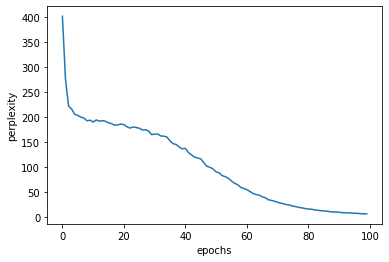

In [7]:
%matplotlib inline
import sys
sys.path.append('..')
import matplotlib.pyplot as plt
import numpy as np
from common.optimizer import SGD
from dataset import ptb
from simple_rnnlm import SimpleRnnlm


# 하이퍼파라미터 설정
batch_size = 10
wordvec_size = 100
hidden_size = 100 # RNN의 은닉 상태 벡터의 원소 수
time_size = 5     # Truncated BPTT가 한 번에 펼치는 시간 크기
lr = 0.1
max_epoch = 100

# 학습 데이터 읽기(전체 중 1000개만)
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_size = 1000
corpus = corpus[:corpus_size]
vocab_size = int(max(corpus) + 1)

xs = corpus[:-1]  # 입력
ts = corpus[1:]   # 출력(정답 레이블)
data_size = len(xs)
print('말뭉치 크기: %d, 어휘 수: %d' % (corpus_size, vocab_size))

# 학습 시 사용하는 변수
max_iters = data_size // (batch_size * time_size)
time_idx = 0
total_loss = 0
loss_count = 0
ppl_list = []

# 모델 생성
model = SimpleRnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)

# 미니배치의 각 샘플의 읽기 시작 위치를 계산
jump = (corpus_size - 1) // batch_size
offsets = [i * jump for i in range(batch_size)]

for epoch in range(max_epoch):
    for iter in range(max_iters):
        # 미니배치 취득
        batch_x = np.empty((batch_size, time_size), dtype='i')
        batch_t = np.empty((batch_size, time_size), dtype='i')
        for t in range(time_size):
            for i, offset in enumerate(offsets):
                batch_x[i, t] = xs[(offset + time_idx) % data_size]
                batch_t[i, t] = ts[(offset + time_idx) % data_size]
            time_idx += 1

        # 기울기를 구하여 매개변수 갱신
        loss = model.forward(batch_x, batch_t)
        model.backward()
        optimizer.update(model.params, model.grads)
        total_loss += loss
        loss_count += 1

    # 에폭마다 퍼플렉서티 평가
    ppl = np.exp(total_loss / loss_count)
    print('| 에폭 %d | 퍼플렉서티 %.2f'
          % (epoch+1, ppl))
    ppl_list.append(float(ppl))
    total_loss, loss_count = 0, 0

# 그래프 그리기
x = np.arange(len(ppl_list))
plt.plot(x, ppl_list, label='train')
plt.xlabel('epochs')
plt.ylabel('perplexity')
plt.show()

| 에폭 1 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 417.22
| 에폭 2 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 341.37
| 에폭 3 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 242.86
| 에폭 4 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 214.25
| 에폭 5 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 206.59
| 에폭 6 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 206.32
| 에폭 7 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 199.16
| 에폭 8 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 200.12
| 에폭 9 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 195.11
| 에폭 10 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 191.51
| 에폭 11 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 192.65
| 에폭 12 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 189.76
| 에폭 13 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 193.60
| 에폭 14 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 188.69
| 에폭 15 |  반복 1 / 19 | 시간 1[s] | 퍼플렉서티 187.86
| 에폭 16 |  반복 1 / 19 | 시간 1[s] | 퍼플렉서티 192.35
| 에폭 17 |  반복 1 / 19 | 시간 1[s] | 퍼플렉서티 191.03
| 에폭 18 |  반복 1 / 19 | 시간 1[s] | 퍼플렉서티 186.48
| 에폭 19 |  반복 1 / 19 | 시간 1[s] | 퍼플렉서티 182.98
| 에폭 20 |  반복 1 / 19 | 시간 1[s] | 퍼플렉서티 183.31
| 에폭 21 |  반복 1 / 19 | 시간 1[s] | 퍼플렉서티 180.80
| 에폭 22 |  반복 1 / 19 | 시간 1[s] | 퍼플렉서티 179.

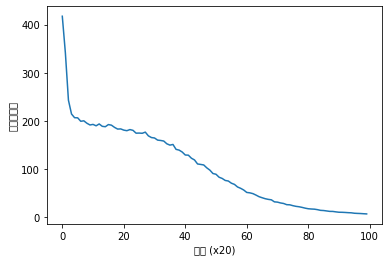

In [8]:
# chap05/train.py
%matplotlib inline
import sys
sys.path.append('..')
from common.optimizer import SGD
from common.trainer import RnnlmTrainer
from dataset import ptb
from simple_rnnlm import SimpleRnnlm


# 하이퍼파라미터 설정
batch_size = 10
wordvec_size = 100
hidden_size = 100  # RNN의 은닉 상태 벡터의 원소 수
time_size = 5  # RNN을 펼치는 크기
lr = 0.1
max_epoch = 100

# 학습 데이터 읽기
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_size = 1000  # 테스트 데이터셋을 작게 설정
corpus = corpus[:corpus_size]
vocab_size = int(max(corpus) + 1)
xs = corpus[:-1]  # 입력
ts = corpus[1:]  # 출력（정답 레이블）

# 모델 생성
model = SimpleRnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

trainer.fit(xs, ts, max_epoch, batch_size, time_size)
trainer.plot()

## 5.6 정리

- RNN은 순환하는 경로가 있고, 이를 통해 내부에 'hidden state'를 기억할 수 있다.

- RNN의 순환 경로를 펼침으로써 다수의 RNN 계층이 연결된 신경망으로 해석할 수 있으며, BPTT로 학습한다.

- 긴 시계열 데이터를 학습할 때는 데이터를 적당한 길이의 블록을 만들어, 블록 단위로 BPTT 로 학습한다(= Truncated BPTT).

- Truncated BPTT에서는 역전파의 연결만 끊는다.

- Truncated BPTT에서는 순전파의 연결을 유지하기 위해 데이터를 '순차적'으로 입력해야 한다.

- 언어 모델은 단어 시퀀스를 확률로 해석한다.

- RNN 계층을 이용한 조건부 언어 모델은 (이론적으로는) 그때까지 등장한 모든 단어의 정보를 기억할 수 있다.